0 [0.14285714 0.1595     0.01035   ] 0.84107826233231
6 [0.19767863 0.10539119 0.01775628] 1.6052187587774513
12 [0.16013404 0.1424477  0.01268374] 1.03224755393162
18 [0.13713066 0.16515204 0.00957453] 0.7848300339098296
24 [0.13898306 0.16332372 0.00982419] 0.802684066235675
30 [0.15180862 0.15066489 0.01154613] 0.9358711670555327
36 [0.14285714 0.1595     0.01035   ] 0.84107826233231
42 [0.12118861 0.18088697 0.00742013] 0.6435689514730102
48 [0.13066738 0.17152468 0.00866732] 0.7251563915879644


Text(0, 0.5, 'Infectados')

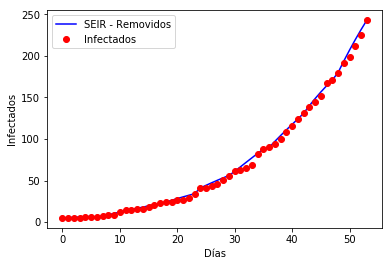

In [89]:
import numpy as np
import matplotlib.pyplot as pl
from scipy import integrate, optimize
from sklearn.metrics import mean_squared_error



p_ll = 2016771

#Columnas 0 infectados, 1 recuperados

LL = np.loadtxt("La_libertad_I_R_F_2.txt")  

file = open("fechas.txt")

line = file.read().split('\n')
file.close()



def sird_model(y, x, beta, gamma, delta):
    #gamma = 1/18
    S = -beta * y[0] * y[1] / N
    R = gamma * y[1]
    D = delta * y[1]
    I = -(S + R + D)
    return S, I, R, D

def fit_odeint0(x, beta, gamma, delta): #SUSCEPTIBLE
    return np.array(integrate.odeint(sird_model, (S0, I0, R0, D0), x, args=(beta, gamma, delta))[:,0])

def fit_odeint1(x, beta, gamma, delta): #INFECTADO
    return np.array(integrate.odeint(sird_model, (S0, I0, R0, D0), x, args=(beta, gamma, delta))[:,1])
    
def fit_odeint2(x, beta, gamma, delta): #RECUPERADO
    return np.array(integrate.odeint(sird_model, (S0, I0, R0, D0), x, args=(beta, gamma, delta))[:,2])

def fit_odeint3(x, beta, gamma, delta): #DIFUNTO
    return np.array(integrate.odeint(sird_model, (S0, I0, R0, D0), x, args=(beta, gamma, delta))[:,3])

p = p_ll

#SE DIVIDE EL TIEMPO EN "n" PARTES
n = 9
N = len(LL[0:,0])
div = [0]
for i in range(1,n+1):
    div.append(int(i*N/n))
    
infec = (LL[:,0])
recu = (LL[:,1]) 
falle = LL[:,2]


valores_iniciales = 1 - (LL[0,0] + LL[0,1] + LL[0,2])/p_ll , LL[0,0]/p_ll , LL[0,1]/p_ll, LL[0,2]/p_ll
t = np.arange(0.0,len(LL[0:,0]),1.0)


Q = np.array([])
R_0 = []
ECM = []
dias   = []
for j in range (0,n):
    

    ydata = LL[div[j]:div[j+1],2]/p
    
        
    xdata = []
    for i in range(0,len(ydata)):
        xdata.append(i)
        
    ydata = np.array(ydata, dtype=float)
    xdata = np.array(xdata, dtype=float)
    
    N = 1.0
    I0 = LL[div[j],0]/p_ll
    R0 = LL[div[j],1]/p_ll
    D0 = ydata[0]
    S0 = N - I0 - R0 - D0
    
    sigma2 = np.ones(len(xdata))
    sigma2[[0, -1]] = 0.01
    popt, pcov = optimize.curve_fit(fit_odeint3, xdata, ydata,sigma = sigma2,bounds=([1.5/21, 0.089 ,  0.0007 ], [1.5/7, 0.230,0.02]))
    #popt, pcov = optimize.curve_fit(fit_odeint3, xdata, ydata,sigma = sigma2,bounds=(0., [1.,1.,1.]))

    print(div[j],popt,popt[0]/(popt[1] + popt[2]))   #DIA , PARAMETROS, R0
    
    R_0.append(popt[0]/(popt[1] + popt[2]))

    
    fitted = fit_odeint3(xdata, *popt)
    
    Q = np.concatenate((Q,fitted[0:div[j+1]-div[j],]),axis = 0)
    
    mse = mean_squared_error(falle[:len(Q)], Q)
    ECM.append(mse)
    dias.append(line[len(Q)])
    


xdata = []
for i in range(0,int(len(LL[0:,0]))):
    xdata.append(i)
    
#xmax = xdata[np.argmax(fitted)]
#ymax = fitted.max()

N = len(LL[0:,0])
ydata = LL[0:,2]


#pl.plot(xdata,F*p,'-r',label = "SEIR - Infectados")
pl.plot(Q*p,'-b',label = "SEIR - Removidos")
pl.plot( ydata, 'or',label = "Infectados")
#pl.plot(LL[0:,1], 'ob',label = "Removidos")
pl.legend(loc=0)
#pl.title("SEIR con $\\beta$ y $\\gamma$ variando cada {} dias".format(int(N/n)))
pl.xlabel('Días')
pl.ylabel('Infectados')
#pl.savefig('SEIR_beta_gamma_LL_I.jpg')

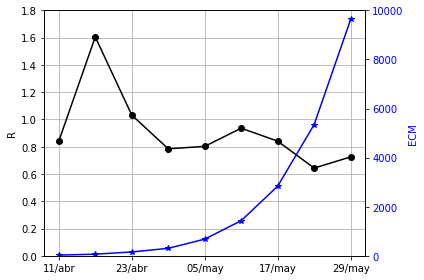

In [92]:
##===================================
#             CON COTA
##===================================



t = dias

fig, ax1 = pl.subplots()




ax1.set_ylabel('R', color='black')
ax1.set_ylim(0,1.8)
ax1.plot(t, R_0, 'ko-')
ax1.tick_params(axis='y', labelcolor='black')


pl.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('ECM', color='blue')  # we already handled the x-label with ax1
ax2.set_ylim(0,10000)
ax2.plot(t, ECM, 'b*-')
ax2.tick_params(axis='y', labelcolor='blue')


pl.xticks(range(0,len(dias),2))


fig.tight_layout()  # otherwise the right y-label is slightly clipped

pl.savefig('R_ECM_acotado.jpg', dpi = 300)

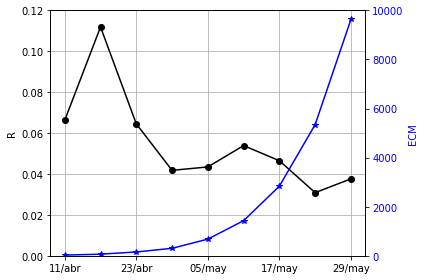

In [88]:
##===================================
#             SIN COTA
##===================================



t = dias

fig, ax1 = pl.subplots()




ax1.set_ylabel('R', color='black')
ax1.set_ylim(0,0.12)
ax1.plot(t, R_0, 'ko-')
ax1.tick_params(axis='y', labelcolor='black')


pl.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('ECM', color='blue')  # we already handled the x-label with ax1
ax2.set_ylim(0,10000)
ax2.plot(t, ECM, 'b*-')
ax2.tick_params(axis='y', labelcolor='blue')


pl.xticks(range(0,len(dias),2))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
pl.savefig('R_ECM_no_acotado.jpg', dpi = 300)

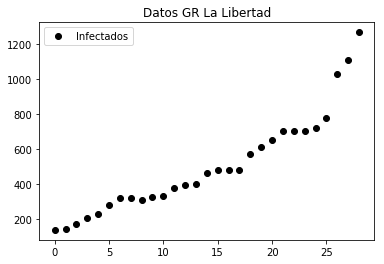

In [22]:
#GRAFICA DE INFECTADOS ACTIVOS
pl.plot( ydata, 'ok',label = "Infectados")
pl.legend(loc=0)
pl.title('Datos GR La Libertad')
pl.savefig('LL.jpg')